# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

[DEBUG] Loading data...
[DEBUG] Data loaded in 00:22:14
Results found in file a-0.png


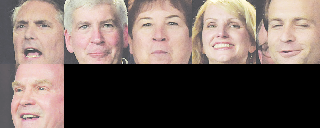

Results found in file a-3.png


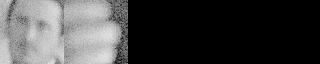

Results found in file a-0.png


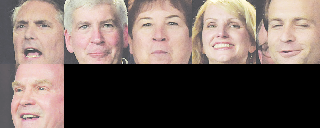

Results found in file a-1.png


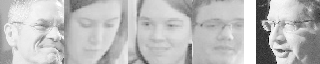

Results found in file a-10.png


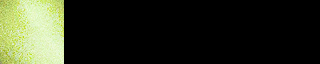

Results found in file a-13.png


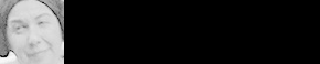

Results found in file a-2.png


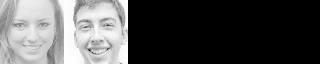

Results found in file a-3.png


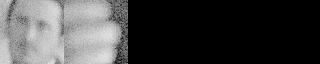

Results found in file a-8.png
But there were no faces in that file!


In [1]:
import zipfile
from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
import io
import math
import time


"""
-------------------------------------------------------------------
    Loading the face detection classifier
-------------------------------------------------------------------
"""
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

"""
-------------------------------------------------------------------
    Data loaded from the zip file
-------------------------------------------------------------------
"""
zip_data = []


"""
-------------------------------------------------------------------
    Hard-coded dimension for normalization
-------------------------------------------------------------------
"""
thumb_dim = 64


"""
-------------------------------------------------------------------
    Hard-coded images per row
-------------------------------------------------------------------
"""
img_per_row = 5


"""
-------------------------------------------------------------------
    Function to load the data from the zip file
-------------------------------------------------------------------
"""
def load_data(zip_file):
    # DEBUG
    print("[DEBUG] Loading data...")
    start_time = time.time()
    # Load the zipfiles
    with zipfile.ZipFile(zip_file, 'r') as zipImages:
        # Open each image
        for image in zipImages.infolist():
            # Image info
            image_name = image.filename
            image_bytes = zipImages.read(image_name)
            # Process image
            process_data(image_name, image_bytes)            
    # DEBUG
    end_time = time.time()
    elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
    print("[DEBUG] Data loaded in {}".format(elapsed_time))


"""
-------------------------------------------------------------------
    Function for the parallel image processing
-------------------------------------------------------------------
"""
def process_data(image_name, image_bytes):
    # Load PIL image from bytes
    image = Image.open(io.BytesIO(image_bytes))
    # Convert PIL image to grayscale
    gray_image = image.convert("L")
    # Convert PIL image to numpy array
    np_image = np.array(gray_image)
    # Detect text with (py)Tesseract
    text = pytesseract.image_to_string(np_image)
    text = text.replace("-\n", "")
    text = text.replace("\n", " ")
    # Detect face boxes with OpenCV
    faces = []
    face_boxes = face_cascade.detectMultiScale(np_image, 1.29, 8)
    for x, y, w, h in face_boxes:
        # Crop original image
        cropped = image.crop((x, y, x + w, y + h))
        # Resize
        resized = cropped.resize((thumb_dim, thumb_dim))
        # Append to the list
        faces.append(resized)
    # Build sheet
    sheet = None
    if len(faces) > 0:
        rows = math.ceil(len(faces) / img_per_row)
        # Build the empty sheet
        sheet = Image.new('RGB', (thumb_dim * img_per_row, thumb_dim * rows))
        # Iterate faces
        x_pos = 0
        y_pos = 0
        for face in faces:
            sheet.paste(face, (x_pos, y_pos))
            x_pos += face.width
            if x_pos >= sheet.width:
                x_pos = 0
                y_pos += face.height
    # Build dictionary
    image_info = { 
        "name": image_name,
        "image": image,
        "text": text,
        "faces": sheet
    }
    zip_data.append(image_info)


"""
-------------------------------------------------------------------
    Function to search the string
-------------------------------------------------------------------
"""
def search_string(word):
    print("----------------------------------------------------------")
    print("Searching for: {}".format(word))
    print("----------------------------------------------------------")
    for data in zip_data:
        if word in data['text']:
            print("Results found in file {}".format(data['name']))
            if data['faces'] is None:
                print("But there were no faces in that file!")
            else:
                display(data['faces'])


"""
-------------------------------------------------------------------
    Main loop
-------------------------------------------------------------------
"""
load_data('readonly/images.zip')
search_string('Christopher')
search_string('Mark')

